Using the other object as test set 🤪

In [1]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

objectwidth = 100
objectheight = 100
xspacing = 116
yspacing = 300
xstart = 293
ystart = 445
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 225

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])

objectinfo = pd.read_csv('Parameters2.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)

del coorddf
del objectCoordinates
del paths_sorted

objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)
objectinfo.reset_index(drop=True, inplace=True)

objects = np.full((len(objectinfo), endlayer, objectheight, objectwidth), np.nan)

for index, object in objectinfo.iterrows():
    objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
del integrals

aggregate = np.sum(objects, axis=(0))

emptyRatio = 30
limit = np.percentile(aggregate, emptyRatio)
testmask = aggregate >= limit

testobjects = objects
testobjectinfo = objectinfo
del objects
del objectinfo

In [2]:
# Read train data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187
separate_test = True
objectsplit = 1
upsamplingratio = 1
positive_multiplier = 1

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

layersPerObject = endlayer // objectsplit
testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
# testEnd = endlayer

objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)

zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
testzs = [objectinfo.copy().assign(zstart=testEnd, zend=endlayer)]
trainobjectinfo = pd.concat(zs, ignore_index=True)
# This line removes all the lines from the dataframe that aren't created because of the positive_multiplier
trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]
testobjectinfo = pd.concat(testzs, ignore_index=True)

trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

del zs
del coorddf
del objectCoordinates
del objectinfo

trainobjects = np.full((len(trainobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), endlayer-testEnd, objectheight, objectwidth), np.nan)

for index, object in trainobjectinfo.iterrows():
    trainobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]
for index, object in testobjectinfo.iterrows():
    testobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

aggregate = np.sum(trainobjects, axis=(0,1))

emptyRatio = 47
limit = np.percentile(aggregate, emptyRatio)
trainmask = aggregate >= limit
trainmask = np.repeat([trainmask], layersPerObject, 0)

testmask = trainmask

del aggregate
del limit
del integrals
del block
del paths

assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [3]:
# Kan skriva min egna convolution?

def convolution2d(image, size):
    kernel = np.ones((size, size))
    output = np.zeros_like(image)
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            output[y, x] = np.nanmean(image[y: y + kernel.shape[0], x: x + kernel.shape[1]])
    return output

<Figure size 432x288 with 0 Axes>

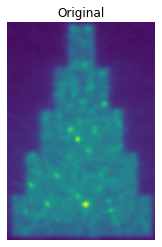

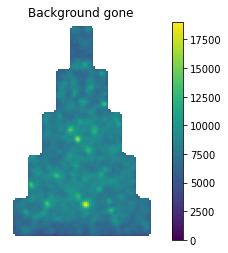

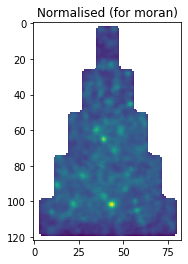

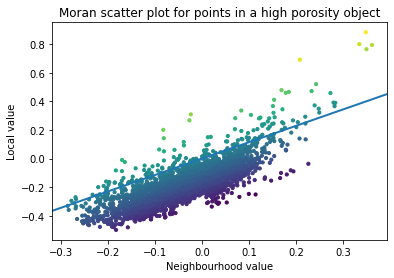

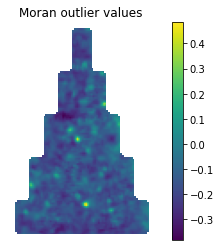

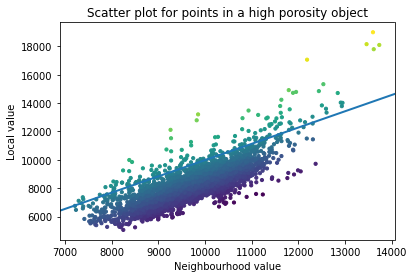

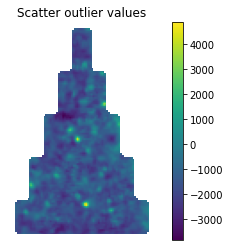

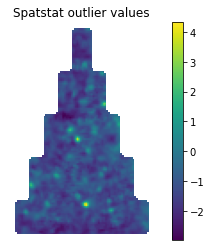

<Figure size 432x288 with 0 Axes>

In [4]:
# Show original
plt.imshow(trainobjects[1, 93], vmin=0)
plt.axis('off')
plt.savefig('figures/originaltree.png', dpi=300, bbox_inches='tight')
plt.title("Original")
plt.figure()

tmpobject = np.copy(trainobjects[1])
tmpobject[~trainmask] = np.nan
plt.imshow(tmpobject[93], vmin=0)
plt.axis('off')
plt.savefig('figures/nobackground.png', dpi=300, bbox_inches='tight')
plt.colorbar()
plt.savefig('figures/nobackgroundcolorbar.png', dpi=300, bbox_inches='tight')
plt.title("Background gone")
plt.figure()

# Show outlier
rtn = np.full(trainobjects.shape, np.nan)
rtnscatter = np.full(trainobjects.shape, np.nan)
    # print(rtn.shape)
for index, object in enumerate(trainobjects):
    xs = np.array(object, copy=True, dtype=np.float32)
    xsscatter = np.array(object, copy=True, dtype=np.float32)
    xsscatter[~trainmask] = np.nan
    rtnscatter[index] = xsscatter
    avg = np.mean(xs, where=trainmask)
    stddev = np.std(xs, where=trainmask)
    xs = (xs - avg) / avg
    xs[~trainmask] = np.nan
    rtn[index] = xs

windowSize = 3
objects = rtn

plt.imshow(objects[1, 93])
plt.title("Normalised (for moran)")
plt.figure()

c, z, y, x = objects.shape
outlierValues = np.full((c, z + 1 - windowSize, y, x), np.nan)
for index, object in enumerate(objects):
    # Step 1: calculate neighbourhood
    neighbourkernel = np.ones((3, 3)) / 9
    flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
    neighbourhoodValues = np.array([
        np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
        for layerIndex in range(windowSize, z+1)
    ])
    # Step 2: calculate outlier
    offset = windowSize // 2
    endoffset = windowSize - offset - 1

    xs = object[offset:z-endoffset]
    ys = neighbourhoodValues[0:z-windowSize+1]
    filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

    assert(len(set(filter.flatten())) == 2)    
    line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
    p = np.poly1d(line)
    outlierValues[index] = xs - p(ys)
    assert(outlierValues[index].shape == xs.shape == p(ys).shape)
    assert(len(np.unique(outlierValues[index])) > 1)
    assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)

    if(index == 1):
        plt.scatter(ys[92].flatten(), xs[92].flatten(), c=(xs - p(ys))[92].flatten(), s=10)
        # plt.scatter(ys2[filter2].flatten(), xs2[filter2].flatten(), color='tab:red', s=10, alpha=0.125)
        plt.axline((-0.1, p(-0.1)), (0, p(0)), linewidth=2, color='tab:blue')
        plt.xlabel("Neighbourhood value")
        plt.ylabel("Local value")
        plt.savefig('figures/moran-color-example.png', dpi=300, bbox_inches='tight')
        plt.title("Moran scatter plot for points in a high porosity object")
        plt.figure()

assert(np.average(np.isfinite(outlierValues)) > 0.4)
plt.imshow(outlierValues[1, 92])
plt.axis('off')
plt.savefig('figures/moranoutliervalues.png', dpi=300, bbox_inches='tight')
plt.colorbar()
plt.savefig('figures/moranoutliercolorbar.png', dpi=300, bbox_inches='tight')
plt.title("Moran outlier values")
plt.figure()



objects = rtnscatter

c, z, y, x = objects.shape
outlierValuesScatter = np.full((c, z + 1 - windowSize, y, x), np.nan)
outlierValuesSpatstat = np.full((c, z + 1 - windowSize, y, x), np.nan)
nhood = np.full((c, z + 1 - windowSize, y, x), np.nan)
for index, object in enumerate(objects):
    # Step 1: calculate neighbourhood
    neighbourkernel = np.ones((3, 3)) / 3**2
    flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
    # funny = np.logical_and(np.isfinite(object), ~np.isfinite(flatNeighbourhood))
    # flatNeighbourhood[funny] = np.nanmean(flatNeighbourhood)
    neighbourhoodValues = np.array([
        np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
        for layerIndex in range(windowSize, z+1)
    ])
    # Step 2: calculate outlier
    offset = windowSize // 2
    endoffset = windowSize - offset - 1

    xs = object[offset:z-endoffset]
    ys = neighbourhoodValues[0:z-windowSize+1]
    filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
    funny = np.logical_and(np.isfinite(xs), ~np.isfinite(ys))


    assert(len(set(filter.flatten())) == 2)    
    line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
    p = np.poly1d(line)
    outlierValuesScatter[index] = xs - p(ys)
    assert(outlierValuesScatter[index].shape == xs.shape == p(ys).shape)
    assert(len(np.unique(outlierValues[index])) > 1)
    assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
    outliers = xs - ys
    avg = np.nanmean(outliers)
    std = np.nanstd(outliers)
    outliers = (outliers - avg) / std
    outlierValuesSpatstat[index] = outliers
    nhood[index] = neighbourhoodValues
    if(index == 1):
        plt.scatter(ys[92].flatten(), xs[92].flatten(), c=(xs - p(ys))[92].flatten(), s=10)
        # plt.scatter(ys2[filter2].flatten(), xs2[filter2].flatten(), color='tab:red', s=10, alpha=0.125)
        plt.axline((10000, p(10000)), (10001, p(10001)), linewidth=2, color='tab:blue')
        plt.xlabel("Neighbourhood value")
        plt.ylabel("Local value")
        plt.savefig('figures/scatter-color-example.png', dpi=300, bbox_inches='tight')
        plt.title("Scatter plot for points in a high porosity object")
        plt.figure()

assert(np.average(np.isfinite(outlierValues)) > 0.4)
plt.imshow(outlierValuesScatter[1, 92])
plt.axis('off')
plt.savefig('figures/scatteroutlier.png', dpi=300, bbox_inches='tight')
plt.colorbar()
plt.savefig('figures/scatteroutliercolorbar.png', dpi=300, bbox_inches='tight')
plt.title("Scatter outlier values")
plt.figure()

plt.imshow(outlierValuesSpatstat[1, 92])
plt.axis('off')
plt.savefig('figures/spatstatoutlier.png', dpi=300, bbox_inches='tight')
plt.colorbar()
plt.savefig('figures/spatstatoutliercolorbar.png', dpi=300, bbox_inches='tight')
plt.title("Spatstat outlier values")
plt.figure()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

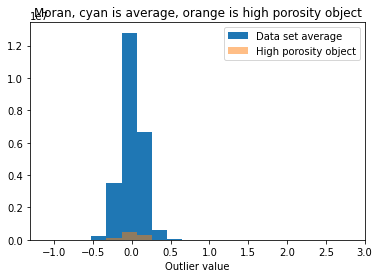

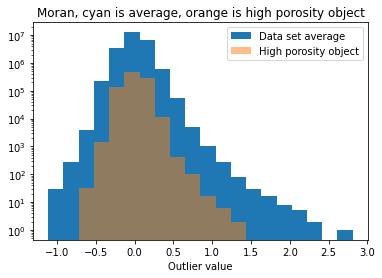

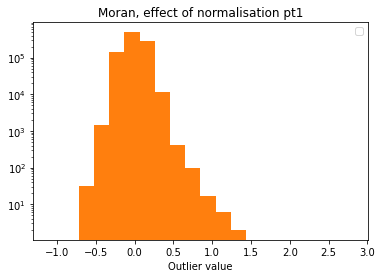

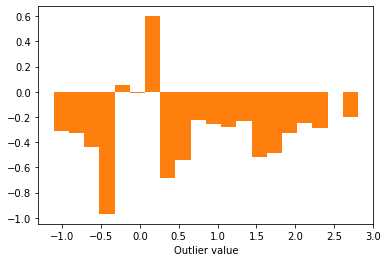

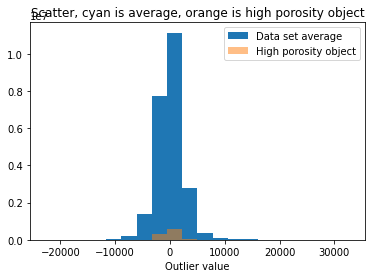

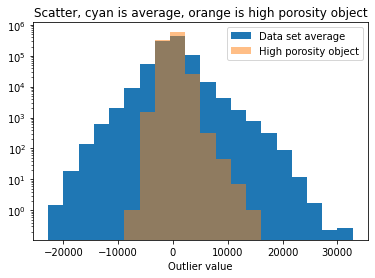

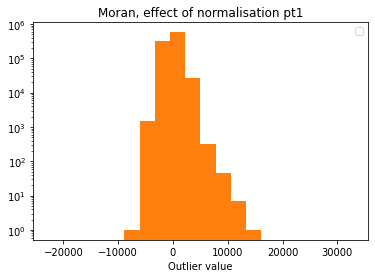

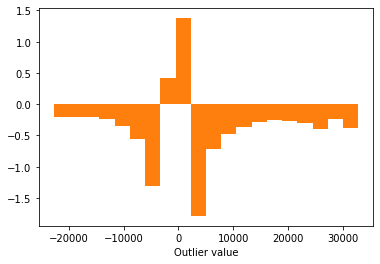

<Figure size 432x288 with 0 Axes>

In [52]:
# Show Moran object and all objects
from sklearn.preprocessing import StandardScaler
labels = np.array(trainobjectinfo.loc[:,"Label"])
# Show histogram for validation
# plt.hist(outlierValues[1].flatten(), bins=20, density=True)
# plt.yscale('log')
# plt.figure()

c, z, y, x = outlierValues.shape
X = np.full((c, 20), np.nan)
raw = np.concatenate([oo.flatten() for oo in outlierValues])
minval = np.nanmin(raw) 
maxval = np.nanmax(raw)
for index in range(0, c):
    xs = outlierValues[index]
    hist, edges = np.histogram(xs, bins=20, range=(minval, maxval))
    X[index] = np.array(hist)
plt.hist(edges[0:-1], weights=np.sum(X,0)/26, bins=edges, color='tab:blue',  label="Data set average")
plt.hist(edges[0:-1], weights=X[1], bins=edges, color='tab:orange',  label="High porosity object", alpha=0.5)
# plt.bar(edges[0:-1], height=X[1], width=(edges[0]-edges[1])/2, color = 'tab:orange', edgecolor='tab:orange', label="High porosity object")
plt.legend()
plt.xlabel("Outlier value")
plt.savefig('figures/moranhist.png', dpi=300, bbox_inches='tight')
plt.title("Moran, cyan is average, orange is high porosity object")
plt.figure()
plt.hist(edges[0:-1], weights=np.sum(X,0)/26, bins=edges, color='tab:blue',  label="Data set average")
plt.hist(edges[0:-1], weights=X[1], bins=edges, color='tab:orange',  label="High porosity object", alpha=0.5)
# plt.bar(edges[0:-1], height=X[1], width=(edges[0]-edges[1])/2, color = 'tab:orange', edgecolor='tab:orange', label="High porosity object")
plt.legend()
plt.xlabel("Outlier value")
plt.yscale('log')
plt.savefig('figures/moranhistlog.png', dpi=300, bbox_inches='tight')
plt.title("Moran, cyan is average, orange is high porosity object")
plt.figure()

# # Attempt 2
# plt.bar(edges[0:-1], height=np.sum(X,0)/26, width=(edges[0]-edges[1]), color = 'tab:blue', label="Average", align='edge')
# plt.bar(edges[0:-1], height=X[1], width=(edges[0]-edges[1]), color = 'tab:orange', label="High porosity object", align='edge', alpha=0.5)
# plt.figure()
# # End
plt.bar(edges[0:-1], height=X[1], width=edges[1]-edges[0], color='tab:orange', align='edge', )
plt.legend()
plt.xlabel("Outlier value")
plt.yscale('log')
plt.savefig('figures/moranprenormalisation.png', dpi=300, bbox_inches='tight')
plt.title("Moran, effect of normalisation pt1")
plt.figure()

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)
plt.bar(edges[0:-1], height=Xtrain[1], width=edges[1]-edges[0], color='tab:orange', align='edge')
plt.xlabel("Outlier value")
plt.savefig('figures/moranpostnormalisation.png', dpi=300, bbox_inches='tight')
plt.figure()

#################################################################################################################

# Show Scatter object and all objects
c, z, y, x = outlierValuesScatter.shape
X = np.full((c, 20), np.nan)
raw = np.concatenate([oo.flatten() for oo in outlierValuesScatter])
minval = np.nanmin(raw) 
maxval = np.nanmax(raw)
for index in range(0, c):
    xs = outlierValuesScatter[index]
    hist, edges = np.histogram(xs, bins=20, range=(minval, maxval))
    X[index] = np.array(hist)
plt.hist(edges[0:-1], weights=np.sum(X,0)/26, bins=edges, color='tab:blue',  label="Data set average")
plt.hist(edges[0:-1], weights=X[1], bins=edges, color='tab:orange',  label="High porosity object", alpha=0.5)
# plt.bar(edges[0:-1], height=X[1], width=(edges[0]-edges[1])/2, color = 'tab:orange', edgecolor='tab:orange', label="High porosity object")
plt.legend()
plt.xlabel("Outlier value")
plt.savefig('figures/scatterhist.png', dpi=300, bbox_inches='tight')
plt.title("Scatter, cyan is average, orange is high porosity object")
plt.figure()
plt.hist(edges[0:-1], weights=np.sum(X,0)/26, bins=edges, color='tab:blue',  label="Data set average")
plt.hist(edges[0:-1], weights=X[1], bins=edges, color='tab:orange',  label="High porosity object", alpha=0.5)
# plt.bar(edges[0:-1], height=X[1], width=(edges[0]-edges[1])/2, color = 'tab:orange', edgecolor='tab:orange', label="High porosity object")
plt.legend()
plt.xlabel("Outlier value")
plt.yscale('log')
plt.savefig('figures/scatterhistlog.png', dpi=300, bbox_inches='tight')
plt.title("Scatter, cyan is average, orange is high porosity object")
plt.figure()

# # Attempt 2
# plt.bar(edges[0:-1], height=np.sum(X,0)/26, width=(edges[0]-edges[1]), color = 'tab:blue', label="Average", align='edge')
# plt.bar(edges[0:-1], height=X[1], width=(edges[0]-edges[1]), color = 'tab:orange', label="High porosity object", align='edge', alpha=0.5)
# plt.figure()
# # End
plt.bar(edges[0:-1], height=X[1], width=edges[1]-edges[0], color='tab:orange', align='edge', )
plt.legend()
plt.xlabel("Outlier value")
plt.yscale('log')
plt.savefig('figures/scatterprenormalisation.png', dpi=300, bbox_inches='tight')
plt.title("Moran, effect of normalisation pt1")
plt.figure()

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)
plt.bar(edges[0:-1], height=Xtrain[1], width=edges[1]-edges[0], color='tab:orange', align='edge')
plt.xlabel("Outlier value")
plt.savefig('figures/scatterpostnormalisation.png', dpi=300, bbox_inches='tight')
plt.figure()

<Figure size 432x288 with 0 Axes>

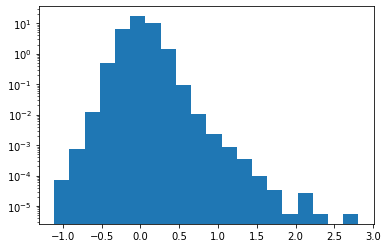

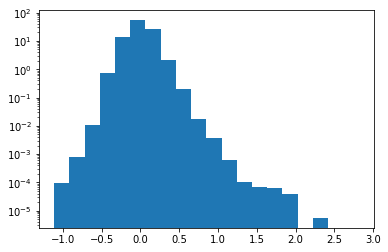

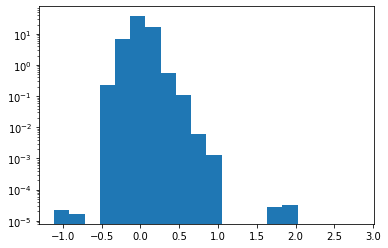

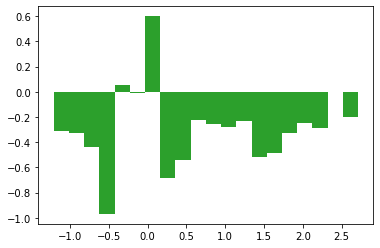

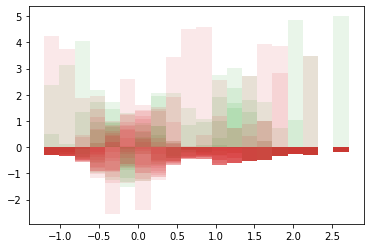

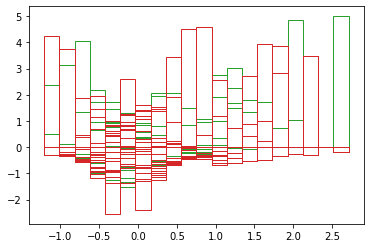

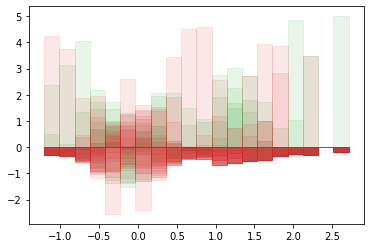

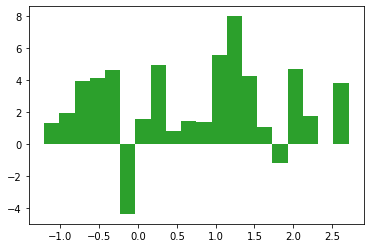

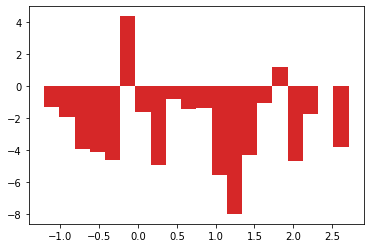

<Figure size 432x288 with 0 Axes>

In [128]:
from sklearn.preprocessing import StandardScaler
labels = np.array(trainobjectinfo.loc[:,"Label"])
# Show histogram for validation
# plt.hist(outlierValues[1].flatten(), bins=20, density=True)
# plt.yscale('log')
# plt.figure()

c, z, y, x = outlierValues.shape
X = np.full((c, 20), np.nan)
raw = np.concatenate([oo.flatten() for oo in outlierValues])
minval = np.nanmin(raw) 
maxval = np.nanmax(raw)
for index in range(0, c):
    xs = outlierValues[index]
    hist, edges = np.histogram(xs, bins=20, range=(minval, maxval), density=True)
    X[index] = np.array(hist)

plt.hist(edges[0:-1], weights=np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.figure()
plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0), bins=edges)
plt.yscale('log')
plt.figure()

plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0) - np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.figure()

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)
plt.bar(edges[0:-1], height=Xtrain[1], width=edges[0]-edges[1], color='tab:green')
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:red', alpha=0.1)

plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='none')
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='none')

plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='tab:red', alpha=0.1)

plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 1],0), width=edges[0]-edges[1], color='tab:green')
plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 0],0), width=edges[0]-edges[1], color='tab:red')
plt.figure()

# print(Xtrain[labels == 0])

# Show histogram after normalisation


<Figure size 432x288 with 0 Axes>

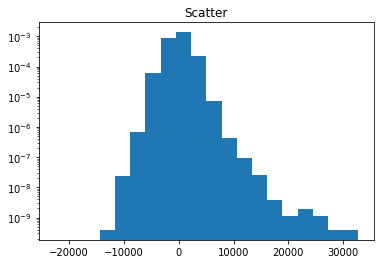

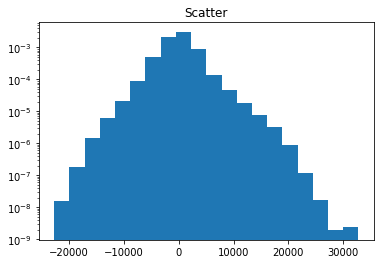

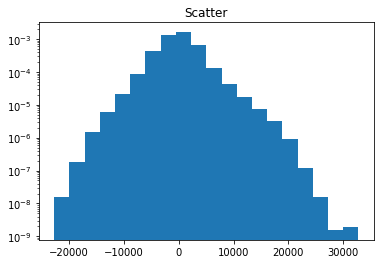

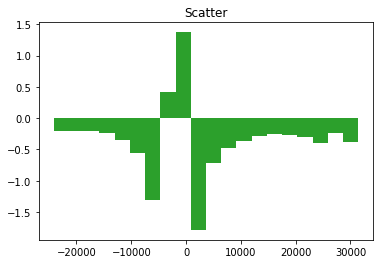

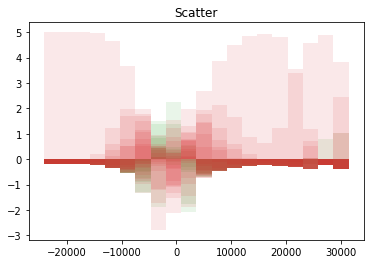

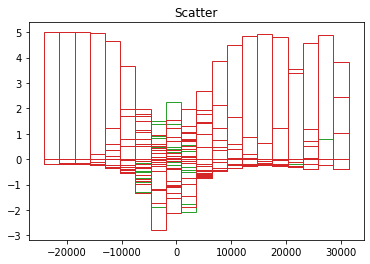

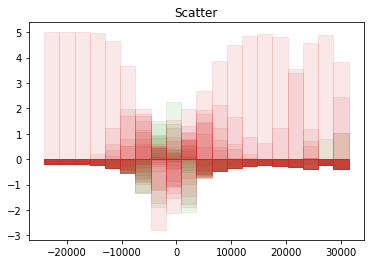

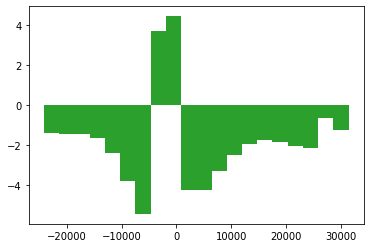

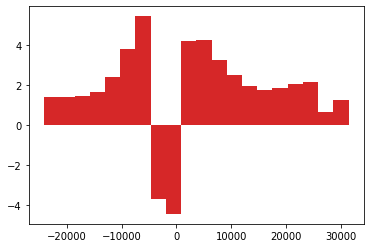

<Figure size 432x288 with 0 Axes>

In [163]:
from sklearn.preprocessing import StandardScaler
labels = np.array(trainobjectinfo.loc[:,"Label"])
# Show histogram for validation
# plt.hist(outlierValues[1].flatten(), bins=20, density=True)
# plt.yscale('log')
# plt.figure()

c, z, y, x = outlierValuesScatter.shape
X = np.full((c, 20), np.nan)
raw = np.concatenate([oo.flatten() for oo in outlierValuesScatter])
minval = np.nanmin(raw) 
maxval = np.nanmax(raw)
for index in range(0, c):
    xs = outlierValuesScatter[index]
    hist, edges = np.histogram(xs, bins=20, range=(minval, maxval), density=True)
    X[index] = np.array(hist)

plt.hist(edges[0:-1], weights=np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.title("Scatter")
plt.figure()
plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0), bins=edges)
plt.yscale('log')
plt.title("Scatter")
plt.figure()

plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0) - np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.title("Scatter")
plt.figure()

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)
plt.bar(edges[0:-1], height=Xtrain[1], width=edges[0]-edges[1], color='tab:green')
plt.title("Scatter")
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:red', alpha=0.1)

plt.title("Scatter")
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='none')
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='none')

plt.title("Scatter")
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='tab:red', alpha=0.1)

plt.title("Scatter")
plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 1],0), width=edges[0]-edges[1], color='tab:green')
plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 0],0), width=edges[0]-edges[1], color='tab:red')
plt.figure()

# print(Xtrain[labels == 0])

# Show histogram after normalisation


<Figure size 432x288 with 0 Axes>

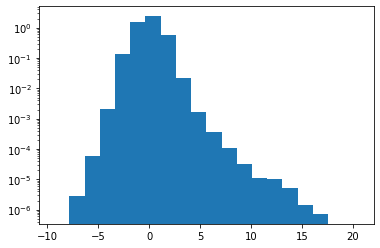

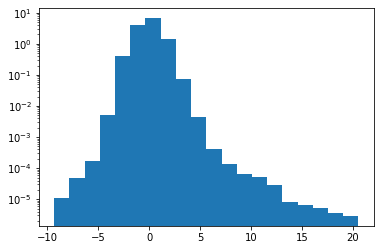

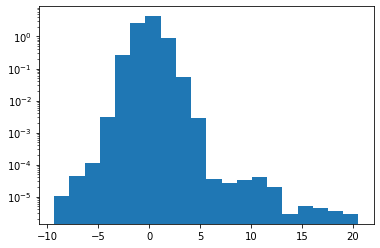

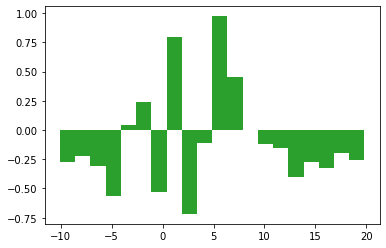

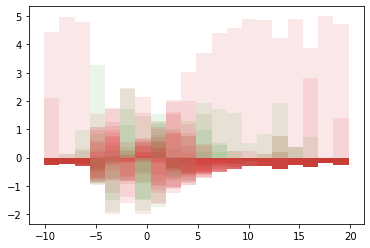

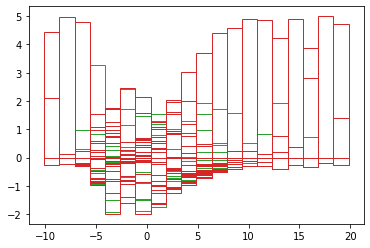

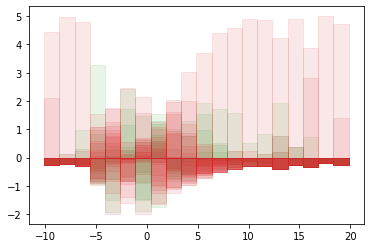

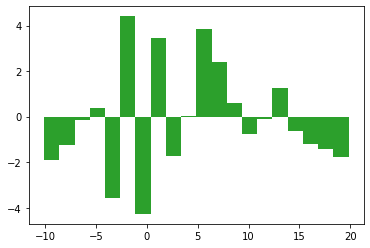

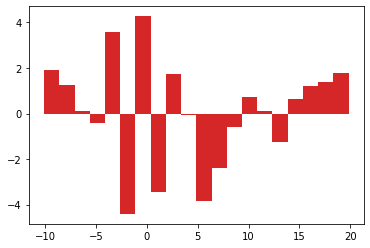

<Figure size 432x288 with 0 Axes>

In [130]:
from sklearn.preprocessing import StandardScaler
labels = np.array(trainobjectinfo.loc[:,"Label"])
# Show histogram for validation
# plt.hist(outlierValues[1].flatten(), bins=20, density=True)
# plt.yscale('log')
# plt.figure()

print("Spatstats")
c, z, y, x = outlierValuesSpatstat.shape
X = np.full((c, 20), np.nan)
raw = np.concatenate([oo.flatten() for oo in outlierValuesSpatstat])
minval = np.nanmin(raw) 
maxval = np.nanmax(raw)
for index in range(0, c):
    xs = outlierValuesSpatstat[index]
    hist, edges = np.histogram(xs, bins=20, range=(minval, maxval), density=True)
    X[index] = np.array(hist)

plt.hist(edges[0:-1], weights=np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.title("Spatstat")
plt.figure()
plt.title("Spatstat")
plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0), bins=edges)
plt.yscale('log')
plt.figure()

plt.hist(edges[0:-1], weights=np.sum(X[labels == 0],0) - np.sum(X[labels == 1],0), bins=edges)
plt.yscale('log')
plt.title("Spatstat")
plt.figure()

scaler = StandardScaler()
Xtrain = scaler.fit_transform(X)
plt.bar(edges[0:-1], height=Xtrain[1], width=edges[0]-edges[1], color='tab:green')
plt.title("Spatstat")
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], color='tab:red', alpha=0.1)
plt.title("Spatstat")
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='none')
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='none')

plt.title("Spatstat")
plt.figure()

for index, object in enumerate(Xtrain[labels == 1]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:green', color='tab:green', alpha=0.1)
for index, object in enumerate(Xtrain[labels == 0]):
    plt.bar(edges[0:-1], height=object, width=edges[0]-edges[1], edgecolor='tab:red', color='tab:red', alpha=0.1)

plt.title("Spatstat")
plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 1],0), width=edges[0]-edges[1], color='tab:green')
plt.title("Spatstat")
plt.figure()
plt.bar(edges[0:-1], height=np.sum(Xtrain[labels == 0],0), width=edges[0]-edges[1], color='tab:red')
plt.title("Spatstat")
plt.figure()

# print(Xtrain[labels == 0])

# Show histogram after normalisation
